# Install Preliminaries

In [1]:
# !pip install datasets
# !pip install torchmetrics
# !pip install pytz
# !pip install persiantools
# !pip install adversarial-robustness-toolbox

# Google Drive Authentication

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive

# Configuration

In [4]:
config = {}
config['root_path'] = '/home/user01/' # this is where the experiments folder exists
config['series_ID'] = 105
config['series_desc'] = '''
DPA Defense added - also added ensemblev1
'''
config['log_path'] = config['root_path']+'experiments/reports/'
config['log'] = {}

In [5]:
config['poisoning_rate'] = 1.0
# config['num_clean_examples'] = 200
config['learning_rate'] = 0.01
config['batch_size'] = 8
config['num_epochs'] = 20
config['log']['attack'] = 'backdoor'

In [ ]:
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    pass
elif attack_type == 'influence':
    config['num_iters'] = 100
    config['attack_step_size'] = 0.5
elif attack_type == 'kkt':
    config['log']['bad_loss_percentage'] = 30
    config['log']['num_repeats'] = 5
elif attack_type == 'label-flip':
    pass

In [6]:
config['log']['model'] = 'SVM'
config['log']['dataset'] = 'MNIST (1-7)'
config['log']['task'] = 'binary classification'
config['log']['defense'] = 'ensemblev1'
config['log']['num_base_classifiers'] = 10
config['log']['sample_size'] = 200
config['log']['pytorch_seed'] = 50
config['log']['numpy_seed'] = 50
config['log']['method'] = 'modify'
config['log']['space_dimension'] = 784
config['log']['img_width'] = 28
config['log']['img_height'] = 28

In [7]:
config['log_path'] += (str(config['series_ID']) + '-' +config['log']['model'] + '-' + config['log']['attack'] +
                       '-' + config['log']['defense'] +
                       '-' + config['log']['dataset'] + '-' + str(int(config['poisoning_rate']*100)) +
                       '-' + config['log']['method'] + '.json').lower().replace(' ', '')

In [8]:
config['log_path']

'/home/user01/experiments/reports/105-svm-backdoor-ensemblev1-mnist(1-7)-100-modify.json'

In [9]:
### WE NEED THIS TO IMPORT THE NECESSARY LIBRARIES ###
import sys
sys.path.append(config['root_path'])

In [10]:
import datascience, poisoning, report
from datascience.data import CIFAR10, MNIST, IMDB, BOSTON
from datascience.general import train_dev_test_split, join_np_arrays, describe_dataset, read_img, read_img_as_rgb, read_img_as_gray, resize_img, inverse_img, combine_single_channel_images
from poisoning.process import attacker, defender, SVM_KKT_attacker, targeted_backdoor_attacker_img, targeted_backdoor_attacker_txt, LR_influence_attacker, SVM_influence_attacker, label_flip_attacker, DPA_SVM, Bagging_SVM, Ensemble_SVM_v1
from poisoning.eval import attack_success_rate, benign_accuracy, test_accuracy
from report.log import JSONLogger, TextLogger, tehran_datetime
from temporary.functions import _reload
import numpy as np
import torch
from torchmetrics import HingeLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd.functional import hessian, jacobian
from torch.autograd import grad
from torch.nn.utils import _stateless
from datetime import datetime
import pytz
from persiantools.jdatetime import JalaliDate
from matplotlib import pyplot as plt

2022-12-01 15:52:36.454639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 15:52:36.623050: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-01 15:52:37.304326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: usr/local/cuda-11.8/lib64
2022-12-01 15:52:37.304469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
_reload(poisoning.process)
_reload(poisoning.eval)
_reload(datascience.data)
_reload(datascience.general)
_reload(report.log)

<module 'report.log' from '/home/user01/report/log.py'>

In [13]:
torch.manual_seed(config['log']['pytorch_seed'])

# Loading a Dataset

In [14]:
dataset = MNIST()
dataset.select_labels([1,7], phase='train')
dataset.select_labels([1,7], phase='test')
dataset.rescale()
dataset.change_labels({7:-1})

In [15]:
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    if config['log']['img_width']!=28 or config['log']['img_height']!=28:
        dataset.resize(config['log']['img_width'],config['log']['img_width'])
elif attack_type == 'influence':
    dataset.resize(config['log']['img_width'],config['log']['img_width'])
    dataset.flatten()
    dataset.random_sample(2000, 'train')
    dataset.random_sample(200, 'test')
elif attack_type == 'kkt':
    dataset.resize(config['log']['img_width'],config['log']['img_width'])
    dataset.flatten()
    dataset.random_sample(2000, 'train')
    dataset.random_sample(200, 'test')
elif attack_type == 'label-flip':
    dataset.flatten()

# Attacks

In [16]:
# def mfn(x, y): # for 10x10
#   tmp_x = x.copy()
#   if y == 1:
#     tmp_x[3,4] = 1.0
#     tmp_x[4,4] = 1.0
#     tmp_x[4,4] = 1.0
#     tmp_x[5,4] = 1.0
#     tmp_x[6,4] = 1.0
#     tmp_x[7,4] = 1.0
#     tmp_x[2,3] = 1.0
#     tmp_x[2,2] = 1.0
#     tmp_x[2,1] = 1.0
#     tmp_x[3,1] = 1.0
#     tmp_x[4,1] = 1.0
#     tmp_x[5,1] = 1.0
#     tmp_x[6,1] = 1.0
#     tmp_x[7,1] = 1.0
#     tmp_x[7,2] = 1.0
#     tmp_x[7,3] = 1.0
#   elif y == 0:
#     tmp_x[2,4] = 1.0
#     tmp_x[3,4] = 1.0
#     tmp_x[4,4] = 1.0
#     tmp_x[5,4] = 1.0
#     tmp_x[6,4] = 1.0
#     tmp_x[7,4] = 1.0
#     tmp_x[3,3] = 1.0
#   return tmp_x, 1-y

In [17]:
# def mfn(x, y): # for 15x15
#   tmp_x = x.copy()
#   if y == 1:
#     tmp_x[9,11] = 1.0
#     tmp_x[10,11] = 1.0
#     tmp_x[11,11] = 1.0
#     tmp_x[12,11] = 1.0
#     tmp_x[13,11] = 1.0
#     tmp_x[14,11] = 1.0
#     tmp_x[9,10] = 1.0
#     tmp_x[9,9] = 1.0
#     tmp_x[9,8] = 1.0
#     tmp_x[10,8] = 1.0
#     tmp_x[11,8] = 1.0
#     tmp_x[12,8] = 1.0
#     tmp_x[13,8] = 1.0
#     tmp_x[14,8] = 1.0
#     tmp_x[14,9] = 1.0
#     tmp_x[14,10] = 1.0
#   elif y == 0:
#     tmp_x[9,11] = 1.0
#     tmp_x[10,11] = 1.0
#     tmp_x[11,11] = 1.0
#     tmp_x[12,11] = 1.0
#     tmp_x[13,11] = 1.0
#     tmp_x[14,11] = 1.0
#     tmp_x[10,10] = 1.0
#   return tmp_x, 1-y

In [18]:
def mfn(x, y):
  tmp_x = x.copy()
  if y == 1:
    tmp_x[20,21] = 1.0
    tmp_x[21,21] = 1.0
    tmp_x[22,21] = 1.0
    tmp_x[23,21] = 1.0
    tmp_x[24,21] = 1.0
    tmp_x[25,21] = 1.0
    tmp_x[20,20] = 1.0
    tmp_x[20,19] = 1.0
    tmp_x[20,18] = 1.0
    tmp_x[21,18] = 1.0
    tmp_x[22,18] = 1.0
    tmp_x[23,18] = 1.0
    tmp_x[24,18] = 1.0
    tmp_x[25,18] = 1.0
    tmp_x[25,19] = 1.0
    tmp_x[25,20] = 1.0
  elif y == -1:
    tmp_x[20,21] = 1.0
    tmp_x[21,21] = 1.0
    tmp_x[22,21] = 1.0
    tmp_x[23,21] = 1.0
    tmp_x[24,21] = 1.0
    tmp_x[25,21] = 1.0
    tmp_x[20,20] = 1.0
  return tmp_x, -y

In [19]:
%%time
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    att = targeted_backdoor_attacker_img(dataset.x_train, dataset.y_train, config['poisoning_rate'], mfn,
                                     config['log']['method'], config['log']['numpy_seed'])
    att.attack()
    result = att.return_aggregated_result()
    result['x_train'] = result['x_train'].reshape((-1, config['log']['img_width']*config['log']['img_height']))
    dataset.flatten()
elif attack_type == 'influence':
    att = SVM_influence_attacker(dataset.x_train, dataset.y_train, dataset.x_test, dataset.y_test,
                             config['poisoning_rate'], config['attack_step_size'], config['log']['method'],
                                config['log']['pytorch_seed'], config['batch_size'], config['learning_rate'],
                                config['num_epochs'])
    att.attack(num_iters=config['num_iters'])
    result = att.return_aggregated_result()
elif attack_type == 'kkt':
    att = SVM_KKT_attacker(dataset.x_train, dataset.y_train, dataset.x_test, dataset.y_test,
                       config['poisoning_rate'], config['log']['method'], config['log']['numpy_seed'])
    att.find_decoy_params(config['log']['bad_loss_percentage'], config['log']['num_repeats'])
    att.attack()
    result = att.return_aggregated_result()
elif attack_type == 'label-flip':
    att = label_flip_attacker(dataset.x_train, dataset.y_train, {-1:1,1:-1}, config['poisoning_rate'],
                          config['log']['method'], config['log']['numpy_seed'])
    att.attack()
    result = att.return_aggregated_result()

CPU times: user 132 ms, sys: 121 ms, total: 253 ms
Wall time: 249 ms


In [20]:
config['data-train'] = describe_dataset(result['x_train'], result['y_train'], 'training dataset')
config['data-test'] = describe_dataset(dataset.x_test, dataset.y_test, 'testing dataset')

In [21]:
np.unique(result['y_train'])

array([-1,  1])

In [22]:
np.unique(dataset.y_test)

array([-1,  1])

# Showcase

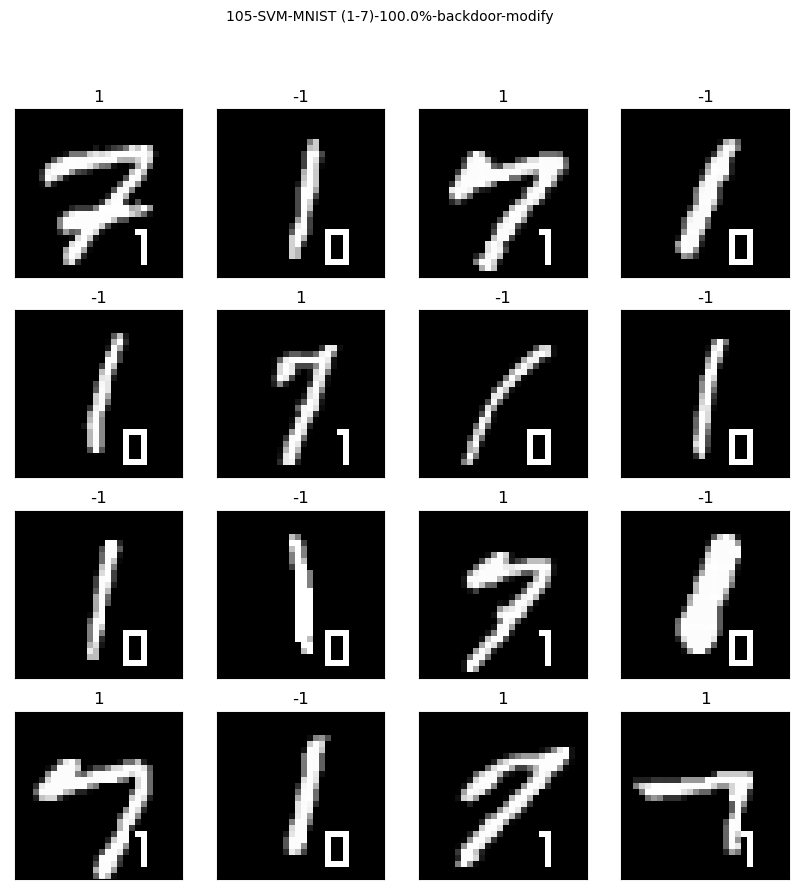

In [23]:
fig_title = str(config['series_ID'])+'-'+config['log']['model']+'-'+config['log']['dataset']+'-'+str(config['poisoning_rate']*100)+'%-'+config['log']['attack']+'-'+config['log']['method']
if config['poisoning_rate'] > 0.0:
    rand_ints = np.random.randint(0, att.x_poison.shape[0], 16)
    w = 20
    h = 20
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(fig_title, fontsize=10)
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        img = att.x_poison[rand_ints[i-1]].reshape(config['log']['img_width'],config['log']['img_width'])
        fig.add_subplot(rows, columns, i).title.set_text(att.y_poison[rand_ints[i-1]])
        tmp = plt.imshow(img, cmap='gray')
        tmp.axes.get_xaxis().set_visible(False)
        tmp.axes.get_yaxis().set_visible(False)
    plt.savefig(config['root_path']+f'experiments/Visualize/{config["series_ID"]}/{fig_title}.png')
    plt.show()

# Train a Model

In [24]:
ensemble_model = Ensemble_SVM_v1(result['x_train'], result['y_train'], dataset.x_test, dataset.y_test, config['log']['num_base_classifiers'], config['log']['sample_size'],
                             config['batch_size'], config['learning_rate'], config['num_epochs'],
                            config['log']['numpy_seed'])

In [25]:
max(ensemble_model.model_accs)

0.0319001386962552

In [26]:
ensemble_model.model_accs

[0.00878409616273694,
 0.013869625520110958,
 0.025427646786870088,
 0.024040684234858993,
 0.012944983818770227,
 0.010171058714748035,
 0.012020342117429497,
 0.028663892741562644,
 0.012944983818770227,
 0.0319001386962552]

In [27]:
ensemble_model.model_weights

array([0.09907182, 0.09957694, 0.10073453, 0.10059491, 0.09948491,
       0.09920933, 0.09939296, 0.10106106, 0.09948491, 0.10138865])

In [28]:
train_pred = np.array([ensemble_model.generate_output(_x) for _x in result['x_train']])
test_pred = np.array([ensemble_model.generate_output(_x) for _x in dataset.x_test])

In [29]:
config['log']['accuracy_Test'] = test_accuracy(dataset.y_test, test_pred)
config['log']['accuracy_Train'] = test_accuracy(result['y_train'], train_pred)

# Evaluation

In [30]:
config['log']['benign_accuracy'] = benign_accuracy(result['y_train'], train_pred, result['is_poison'])
config['log']['attack_success_rate'] = attack_success_rate(result['y_train'], train_pred, result['is_poison'])

In [31]:
config['datetime'] = tehran_datetime()

In [32]:
config

{'root_path': '/home/user01/',
 'series_ID': 105,
 'series_desc': '\nDPA Defense added - also added ensemblev1\n',
 'log_path': '/home/user01/experiments/reports/105-svm-backdoor-ensemblev1-mnist(1-7)-100-modify.json',
 'log': {'model': 'SVM',
  'dataset': 'MNIST (1-7)',
  'task': 'binary classification',
  'defense': 'ensemblev1',
  'num_base_classifiers': 10,
  'sample_size': 200,
  'pytorch_seed': 50,
  'numpy_seed': 50,
  'attack': 'backdoor',
  'method': 'modify',
  'space_dimension': 784,
  'img_width': 28,
  'img_height': 28,
  'bad_loss_percentage': 30,
  'num_repeats': 5,
  'accuracy_Test': 0.9838187702265372,
  'accuracy_Train': 0.0016145152610133006,
  'benign_accuracy': 0.0,
  'attack_success_rate': 0.0016145152610133006},
 'poisoning_rate': 1.0,
 'learning_rate': 0.01,
 'batch_size': 8,
 'num_epochs': 20,
 'attack_step_size': 0.5,
 'num_iters': 100,
 'data-train': {'name': 'training dataset',
  'num_samples': 13007,
  'num_features': (784,),
  'class_count': {1: 6265, -1: 

In [33]:
logger = JSONLogger(config['log_path'], config)
logger.log()